# Part 2: Training  
In this part we will show how using MLRun's **Feature Store** we can easily define a **Feature Vector** and create the dataset we need to run our training process.  

We will see how to:
- Combine multiple data sources to a single Feature Vector
- Create training dataset
- Create a model using an MLRun Hub function

<img src="../../_static/images/feature_store_demo_diagram.png" width="600px" />

## Environment Setup

Since our work is done in a this project scope, we will first want to define the project itself for all our MLRun work in this notebook.

In [ ]:
import mlrun
from os import getenv

project, _ = mlrun.set_environment(project='fsdemo', user_project=True)
# location of the output data files
data_path = f"{getenv('V3IO_HOME_URL')}/demos/feature-store/data/"

## Create Feature Vector  
In this section we will create our Feature Vector.  
The Feature vector will have a `name` so we can reference to it later via the UI or our serving function, and a list of `features` from the available FeatureSets.  We can add a feature from a feature set by adding `<FeatureSet>.<Feature>` to the list, or add `<FeatureSet>.*` to add all the FeatureSet's available features.  
The `Label` is added explicitely from the available features so we will not look for it when serving in real-time (since it won't be available).

By default, the first FeatureSet in the feature list will act as the spine. meaning that all the other features will be joined to it.  
So for example, in this instance we use the early_sense sensor data as our spine, so for each early_sense event we will create produce a row in the resulted Feature Vector.

In [2]:
# Import MLRun's Feature Store
import mlrun.feature_store as fs

# Define the featuer vector's name for future reference
feature_vector_name = 'patient-deterioration'

# Define the list of features in the feature vector
features = ['early_sense.hr',
            'early_sense.rr',
            'early_sense.hr_h_avg_1h',
            'early_sense.hr_d_avg_1d',
            'early_sense.rr_h_avg_1h',
            'early_sense.rr_d_avg_1d',
            'early_sense.spo2_h_avg_1h',
            'early_sense.spo2_d_avg_1d',
            'early_sense.movements_h_avg_1h',
            'early_sense.movements_d_avg_1d',
            'early_sense.turn_count_h_avg_1h',
            'early_sense.turn_count_d_avg_1d',
            'early_sense.in_bed_h_avg_1h',
            'early_sense.in_bed_d_avg_1d',
            'early_sense.room',
            'early_sense.spo2',
            'early_sense.movements',
            'early_sense.turn_count',
            'early_sense.is_in_bed',
            'early_sense.bed',
            'measurements.agg_sp_0_0_avg_1h',
            'measurements.agg_sp_0_1_avg_1h',
            'measurements.agg_sp_0_2_avg_1h',
            'measurements.agg_sp_1_0_avg_1h',
            'measurements.agg_sp_1_1_avg_1h',
            'measurements.agg_sp_1_2_avg_1h',
            'measurements.agg_sp_2_0_avg_1h',
            'measurements.agg_sp_2_1_avg_1h',
            'measurements.agg_sp_2_2_avg_1h',
            'patient_details.age',
            'patient_details.age_mapped_toddler',
            'patient_details.age_mapped_child',
            'patient_details.age_mapped_adult',
            'patient_details.age_mapped_elder',
            ]

# Define the feature vector
fv = fs.FeatureVector(feature_vector_name, 
                      features, 
                      label_feature="labels.label",
                      description='Predict patient deterioration')

# Save the feature vector in the Feature Store
fv.save()

## Produce training dataset as parquet

In [3]:
# Import the Parquet Target so we can directly save our dataset as a file
from mlrun.datastore.targets import ParquetTarget

# Get offline feature vector
# will return a pandas dataframe and save the dataset to parquet so a 
# training job could train on it
dataset = fs.get_offline_features(feature_vector_name, target=ParquetTarget())

# View dataset example
df = dataset.to_dataframe()
df.head()

> 2021-05-06 15:31:43,798 [info] wrote target: {'name': 'parquet', 'kind': 'parquet', 'path': 'v3io:///projects/fsdemo-admin/fs/parquet/vectors/patient-deterioration-latest.parquet', 'status': 'ready', 'updated': '2021-05-06T15:31:43.798102+00:00'}


,hr,rr,hr_h_avg_1h,hr_d_avg_1d,rr_h_avg_1h,rr_d_avg_1d,spo2_h_avg_1h,spo2_d_avg_1d,movements_avg_h_1h,movements_avg_d_1d,...,agg_sp_1_2_avg_h_1h,agg_sp_2_0_avg_h_1h,agg_sp_2_1_avg_h_1h,agg_sp_2_2_avg_h_1h,age,age_mapped_toddler,age_mapped_child,age_mapped_adult,age_mapped_elder,label
0,220.0,25,220.0,220.0,25.0,25.0,99.0,99.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,65,0,0,0,1,False
1,220.0,25,220.0,220.0,25.0,25.0,99.0,99.0,4.698252,4.698252,...,NaN,NaN,NaN,NaN,72,0,0,0,1,False
2,220.0,25,220.0,220.0,25.0,25.0,99.0,99.0,6.024110,6.024110,...,NaN,NaN,NaN,NaN,49,0,0,1,0,False
3,220.0,25,220.0,220.0,25.0,25.0,99.0,99.0,6.289756,6.289756,...,NaN,NaN,NaN,NaN,37,0,0,1,0,False
4,220.0,25,220.0,220.0,25.0,25.0,99.0,99.0,0.000000,0.000000,...,NaN,NaN,NaN,NaN,82,0,0,0,1,False


**View the dataset details**

In [4]:
df.describe()

**Feature Vector URI for future reference**

In [5]:
fv.uri

'store://feature-vectors/fsdemo-admin/patient-deterioration'

## Upload dataset to blob store

You can optionally store the data to any file/object storage

In [6]:
dataset.to_parquet(data_path + 'patients.parquet')

## Use MLRun AutoML Training over Kubernetes  
Here we will use MLRun to import a training function from our [functions hub](https://github.com/mlrun/functions) and run it on our cluster using our newly defined feature vector.

### Create MLRun Serverless Training Function (from code)

In [7]:
from mlrun.platforms import auto_mount

# Import the SKLearn based training function from our functions hub
fn = mlrun.import_function('hub://sklearn-classifier').apply(auto_mount())

### Run AutoML Training Function over the cluster  
We will use MLRun's HyperParameters mechanism to train 3 different models on the dataset and test them by their accuracy.

> 2021-05-06 15:31:44,538 [info] starting run training uid=5355f4d1c909452fb80cf074af603fa4 DB=http://mlrun-api:8080


Converting input from bool to <class 'numpy.uint8'> for compatibility.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Converting input from bool to <class 'numpy.uint8'> for compatibility.
Converting input from bool to <class 'numpy.uint8'> for compatibility.


> 2021-05-06 15:31:50,772 [info] best iteration=2, used criteria max.accuracy


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
fsdemo-admin,...af603fa4,0,May 06 15:31:44,completed,training,v3io_user=adminkind=owner=admin,dataset,label_column=label,best_iteration=2accuracy=1.0test-error=0.0rocauc=1.0brier_score=2.822807131739259e-14f1-score=1.0precision_score=1.0recall_score=1.0,test_setprobability-calibrationconfusion-matrixfeature-importancesprecision-recall-binaryroc-binarymodeliteration_results


to track results use .show() or .logs() or in CLI: 
!mlrun get run 5355f4d1c909452fb80cf074af603fa4 --project fsdemo-admin , !mlrun logs 5355f4d1c909452fb80cf074af603fa4 --project fsdemo-admin
> 2021-05-06 15:31:51,561 [info] run executed, status=completed


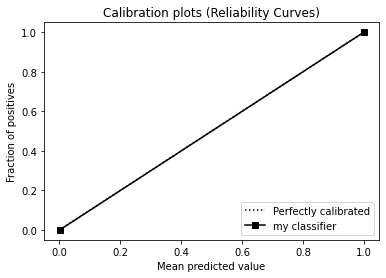

<Figure size 432x288 with 0 Axes>

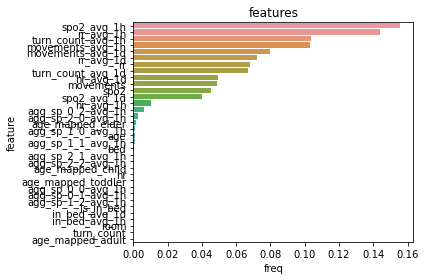

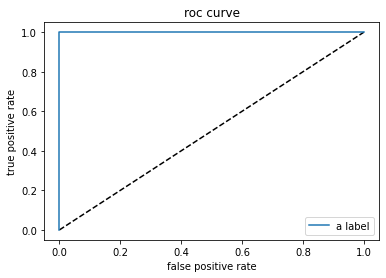

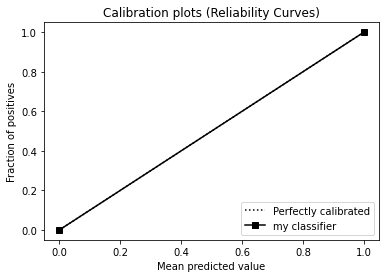

<Figure size 432x288 with 0 Axes>

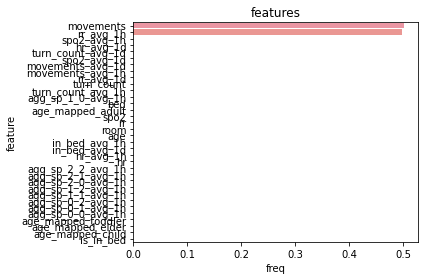

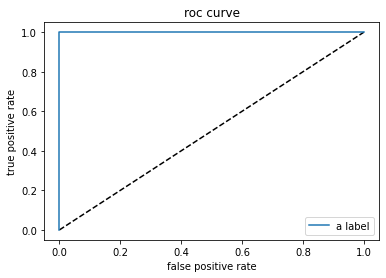

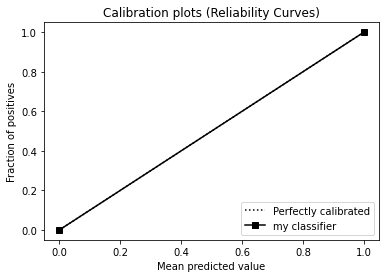

<Figure size 432x288 with 0 Axes>

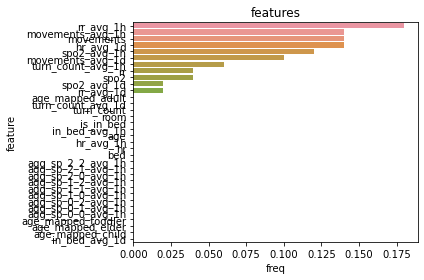

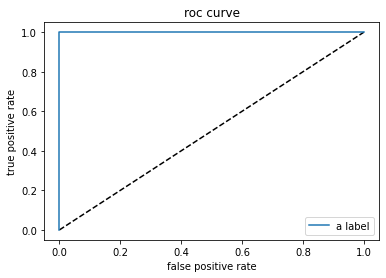

In [8]:
# Prepare the parameters list for the training function
# We define 3 different models to test on our dataset
model_list = {"model_name": ['patient_det_rf', 'patient_det_xgboost', 'patient_det_adaboost'],
              "model_pkg_class": ['sklearn.ensemble.RandomForestClassifier',
                                  'sklearn.ensemble.GradientBoostingClassifier',
                                  'sklearn.ensemble.AdaBoostClassifier']}

# Define the training task, including our feature vector, label and hyperparams definitions
task = mlrun.new_task('training', 
                      inputs={'dataset': f'store://feature-vectors/{project}/{feature_vector_name}'},
                      params={'label_column': 'label'}
                     )
task.with_hyper_params(model_list, strategy='list', selector='max.accuracy')

# Run the function 
fn.spec.image = 'mlrun/ml-models'
run = fn.run(task, local=True)

**View the run outputs, including result metrics and artifacts**

In [9]:
run.outputs

{'best_iteration': 2,
 'accuracy': 1.0,
 'test-error': 0.0,
 'rocauc': 1.0,
 'brier_score': 2.822807131739259e-14,
 'f1-score': 1.0,
 'precision_score': 1.0,
 'recall_score': 1.0,
 'test_set': 'store://artifacts/fsdemo-admin/training_test_set:5355f4d1c909452fb80cf074af603fa4',
 'probability-calibration': '/v3io/projects/fsdemo-admin/artifacts/model/plots/2/probability-calibration.html',
 'confusion-matrix': '/v3io/projects/fsdemo-admin/artifacts/model/plots/2/confusion-matrix.html',
 'feature-importances': '/v3io/projects/fsdemo-admin/artifacts/model/plots/2/feature-importances.html',
 'precision-recall-binary': '/v3io/projects/fsdemo-admin/artifacts/model/plots/2/precision-recall-binary.html',
 'roc-binary': '/v3io/projects/fsdemo-admin/artifacts/model/plots/2/roc-binary.html',
 'model': 'store://artifacts/fsdemo-admin/training_model:5355f4d1c909452fb80cf074af603fa4',
 'iteration_results': '/v3io/projects/fsdemo-admin/artifacts/iteration_results.csv'}

**View the training dataset status**

In [10]:
fs.get_feature_vector(f'{project}/{feature_vector_name}').status.targets['parquet'].to_dict()

{'name': 'parquet',
 'kind': 'parquet',
 'path': 'v3io:///projects/fsdemo-admin/fs/parquet/vectors/patient-deterioration-latest.parquet',
 'status': 'ready',
 'updated': '2021-05-06T15:31:43.798102+00:00'}

## Done!

You've completed the training process. Proceed to [Part 3](03-deploy-serving-model.ipynb) to deploy the model.